In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import pandas as pd
import os
import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import climetlab as cml
import cfgrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob


#SD
from mymetrics import compute_rmse, compute_mae, compute_bias, compute_acc
from data_utils import extract_temp_pressure_level, process_and_combine
#SD

In [45]:
data_dir = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/'
fcn_dir = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/fourcastnet'
pangu_dir = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/pangu'
graphcast_dir = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/graphcast'

india_era5_12_steps = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/my_graphcast_dir/data/era5_data/indian_region_era5_date-2022-01-01_res-0.25_levels-13_steps-12.nc'

india_era5_6_days_6days = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/my_graphcast_dir/data/era5_data/cds-era5-india-20220101-6days.grib'

In [46]:
lead_time = 48      # hours
init_time = 20220101 # yyyymmdd
start_time = '00'
variables = ['t']    # t: temperature
pressure_levels = [500] # 500 hPa corresponds to approx 5 km above sea level
models = ['pangu'] # neuralgcm

# India specific
lat_min, lat_max = 8.0, 37.0
lon_min, lon_max = 68.0, 97.0

In [52]:
current_pangu_dir = f"{pangu_dir}/init{init_time}-lead{lead_time}-t{start_time}-pangu"
current_fcn_dir = f"{fcn_dir}/init{init_time}-lead{lead_time}-t{start_time}-fcn"

pangu0 = f"{pangu_dir}/init{init_time}-lead{lead_time}-t{start_time}-pangu/out-pangu-0.grib"
fcn0 = f"{fcn_dir}/init{init_time}-lead{lead_time}-t{start_time}-fcn/out-FCNv2-0.grib"

fcn_all48 = f"{fcn_dir}/init{init_time}-lead{lead_time}-t{start_time}-fcn/out-FCNv2-whole48.grib"


In [56]:
fcn_48 = cfgrib.open_datasets(fcn_all48)
fcn_48 = xr.merge(fcn_48, compat='override')
fcn_48

<xarray.Dataset> Size: 3GB
Dimensions:            (step: 9, latitude: 721, longitude: 1440,
                        isobaricInhPa: 13)
Coordinates:
    time               datetime64[ns] 8B 2022-01-01
  * step               (step) timedelta64[ns] 72B 0 days 00:00:00 ... 2 days ...
    entireAtmosphere   float64 8B 0.0
  * latitude           (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude          (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
    valid_time         (step) datetime64[ns] 72B ...
    heightAboveGround  float64 8B 10.0
  * isobaricInhPa      (isobaricInhPa) float64 104B 1e+03 925.0 ... 100.0 50.0
    meanSea            float64 8B 0.0
    surface            float64 8B 0.0
Data variables: (12/13)
    tcwv               (step, latitude, longitude) float32 37MB ...
    u10                (step, latitude, longitude) float32 37MB ...
    v10                (step, latitude, longitude) float32 37MB ...
    t2m                (step, latitude, longitude) float32 37MB ...
    u100               (step, latitude, longitude) float32 37MB ...
    v100               (step, latitude, longitude) float32 37MB ...
    ...                 ...
    t                  (step, isobaricInhPa, latitude, longitude) float32 486MB ...
    u                  (step, isobaricInhPa, latitude, longitude) float32 486MB ...
    v                  (step, isobaricInhPa, latitude, longitude) float32 486MB ...
    r                  (step, isobaricInhPa, latitude, longitude) float32 486MB ...
    msl                (step, latitude, longitude) float32 37MB ...
    sp                 (step, latitude, longitude) float32 37MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [48]:
pangu42 = xr.open_dataset(f'{current_pangu_dir}/india_pangu_all42.nc')
india_pangu42 = pangu42
india_pangu42
# india_fcn42

<xarray.Dataset> Size: 34MB
Dimensions:            (step: 9, latitude: 117, longitude: 117,
                        isobaricInhPa: 13)
Coordinates:
    time               datetime64[ns] 8B ...
  * step               (step) timedelta64[ns] 72B 0 days 00:00:00 ... 2 days ...
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 936B 37.0 36.75 36.5 ... 8.5 8.25 8.0
  * longitude          (longitude) float64 936B 68.0 68.25 68.5 ... 96.75 97.0
    valid_time         (step) datetime64[ns] 72B ...
  * isobaricInhPa      (isobaricInhPa) float64 104B 1e+03 925.0 ... 100.0 50.0
    meanSea            float64 8B ...
Data variables:
    u10                (step, latitude, longitude) float32 493kB ...
    v10                (step, latitude, longitude) float32 493kB ...
    t2m                (step, latitude, longitude) float32 493kB ...
    z                  (step, isobaricInhPa, latitude, longitude) float32 6MB ...
    t                  (step, isobaricInhPa, latitude, longitude) float32 6MB ...
    u                  (step, isobaricInhPa, latitude, longitude) float32 6MB ...
    v                  (step, isobaricInhPa, latitude, longitude) float32 6MB ...
    q                  (step, isobaricInhPa, latitude, longitude) float32 6MB ...
    msl                (step, latitude, longitude) float32 493kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [49]:
india_era42 = xr.open_dataset(india_era5_12_steps)
india_era42 = india_era42.sel(
    lat=slice(lat_min, lat_max),
    lon=slice(lon_min, lon_max)
)
india_era42

<xarray.Dataset> Size: 65MB
Dimensions:                       (lon: 117, lat: 117, time: 14, level: 13,
                                   batch: 1)
Coordinates:
  * lon                           (lon) float32 468B 68.0 68.25 ... 96.75 97.0
  * lat                           (lat) float32 468B 8.0 8.25 8.5 ... 36.75 37.0
  * time                          (time) timedelta64[ns] 112B 0 days 00:00:00...
  * level                         (level) int32 52B 50 100 150 ... 850 925 1000
    datetime                      (batch, time) datetime64[ns] 112B ...
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float32 55kB ...
    land_sea_mask                 (lat, lon) float32 55kB ...
    2m_temperature                (batch, time, lat, lon) float32 767kB ...
    mean_sea_level_pressure       (batch, time, lat, lon) float32 767kB ...
    10m_v_component_of_wind       (batch, time, lat, lon) float32 767kB ...
    10m_u_component_of_wind       (batch, time, lat, lon) float32 767kB ...
    ...                            ...
    temperature                   (batch, time, level, lat, lon) float32 10MB ...
    geopotential                  (batch, time, level, lat, lon) float32 10MB ...
    u_component_of_wind           (batch, time, level, lat, lon) float32 10MB ...
    v_component_of_wind           (batch, time, level, lat, lon) float32 10MB ...
    vertical_velocity             (batch, time, level, lat, lon) float32 10MB ...
    specific_humidity             (batch, time, level, lat, lon) float32 10MB ...

In [50]:
results_path = "/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/src/ai_models/results/20220101-42hrs_final/"
india_era42 = india_era42.rename({'lat': 'latitude', 'lon': 'longitude'})

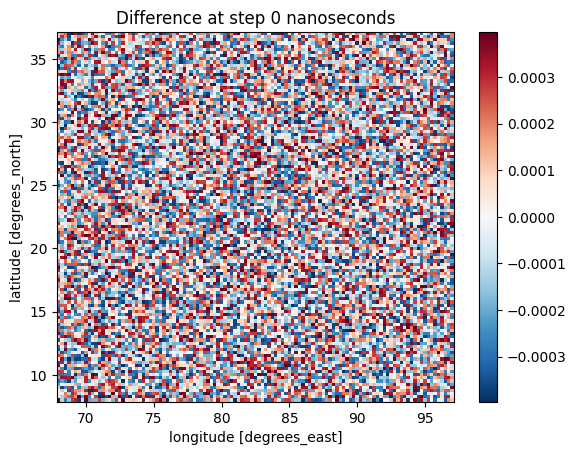

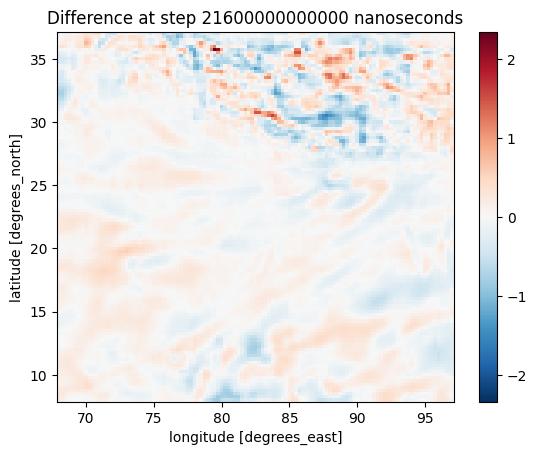

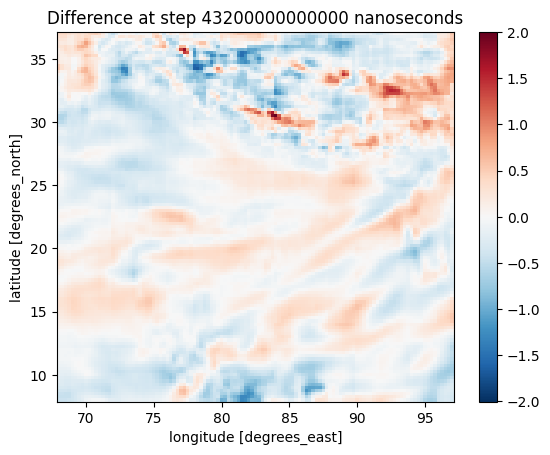

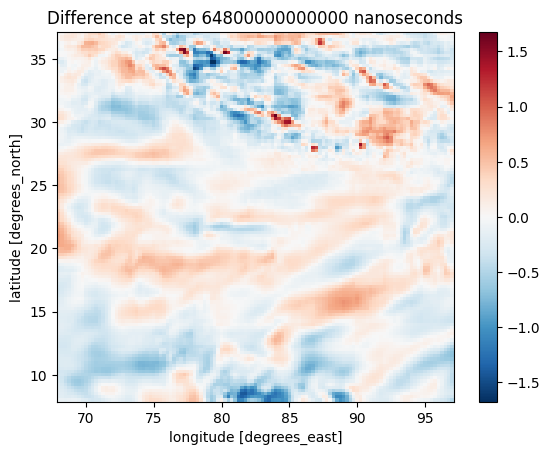

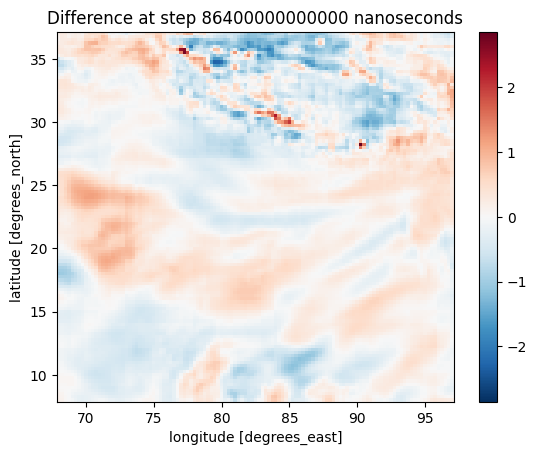

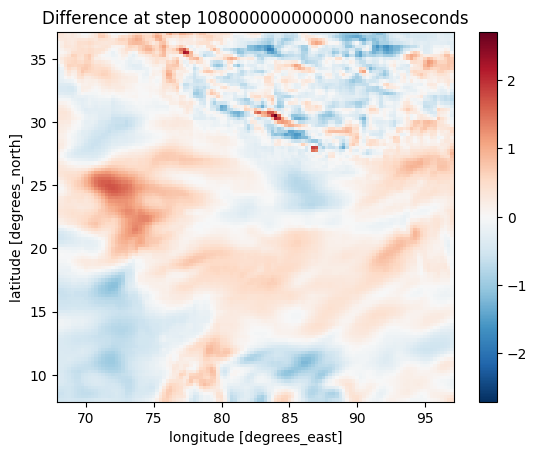

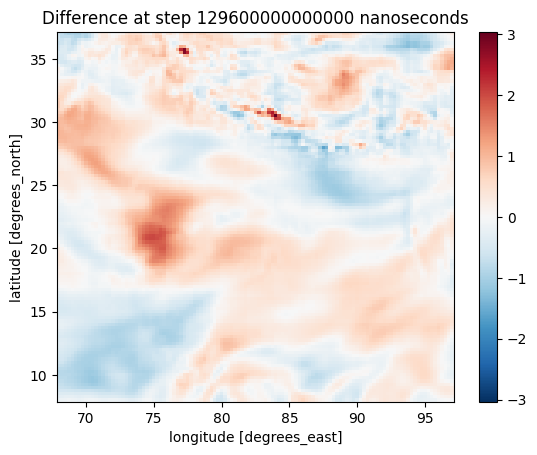

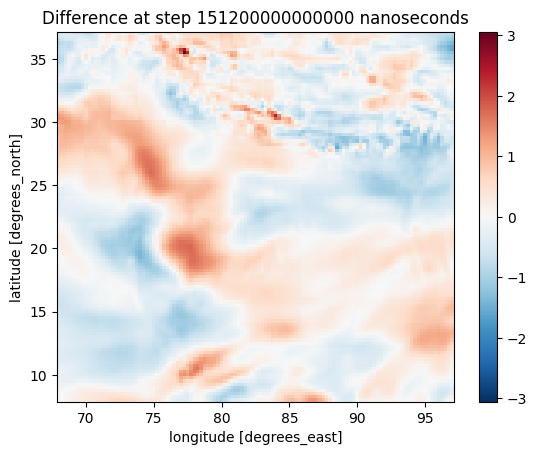

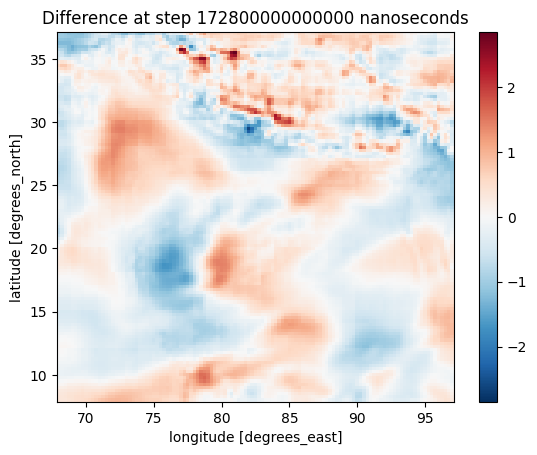

In [51]:
for step in india_pangu42['step']:
    forecast_data = india_pangu42['t'].sel(step=step, isobaricInhPa=500)
    era_data = india_era42['temperature'].sel(time=step, level=500)
    diff = forecast_data - era_data
    diff.plot()
    plt.title(f'Difference at step {step.values}')
    plt.show()


In [ ]:
for model in models:
    for level in pressure_levels:
        for var in variables:
            if model == 'FCN':
                model = 'FCNv2'
                forecast_df = india_fcn42
            elif model == 'pangu':
                forecast_df = india_pangu42
            elif model == 'graphcast':
                # all the graphcast forecast data is in one file so the processing isn't needed for that
                pass
                forecast_path = os.path.join(graphcast_dir, f'{model}_forecast_{var}_{level}hPa_{init_time}_{lead_time}.nc')
            else:
                raise ValueError('Invalid model name')
            
            # find difference between india_era42 and forecast_df for each variable and level
            forecast_data = forecast_df[var].sel(isobaricInhPa=level)
            if var == 't':
                era_data = india_era42["temperature"].sel(level=level)
            diff = forecast_data - era_data
            
diff

: 